In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore') # 計算警告を非表示





In [2]:
# 日付形式で読み込む
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df = pd.read_csv('AirPassengers.csv', index_col='Month', date_parser=dateparse, dtype='float')

In [3]:
df.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


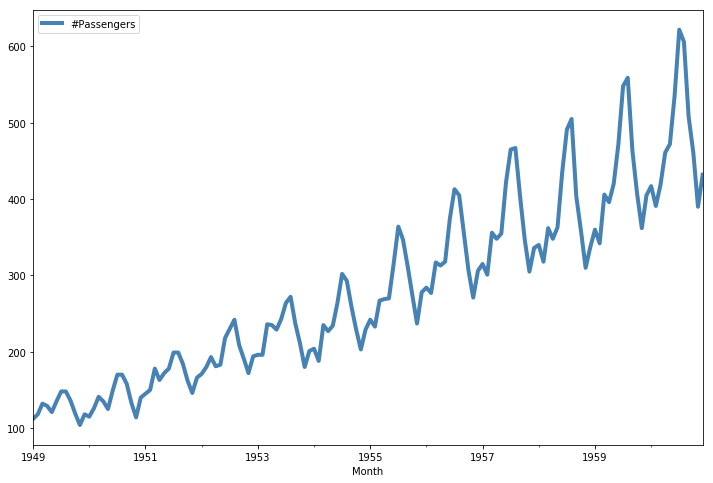

In [4]:
# プロット
plt.rcParams['figure.figsize'] = 12, 8
df.plot(linewidth=4, color="steelblue")


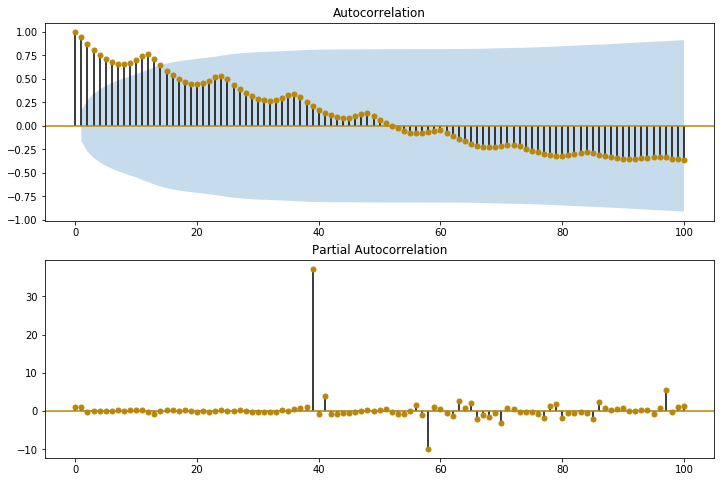

In [5]:
dfa = df.copy()
# 1. 自己相関と季節効果の確認
# 自己相関係数と偏自己相関係数のコレログラムを出力
fig,ax = plt.subplots(2,1,figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(dfa, lags=100, ax=ax[0], color="darkgoldenrod")
fig = sm.graphics.tsa.plot_pacf(dfa, lags=100, ax=ax[1], color="darkgoldenrod")


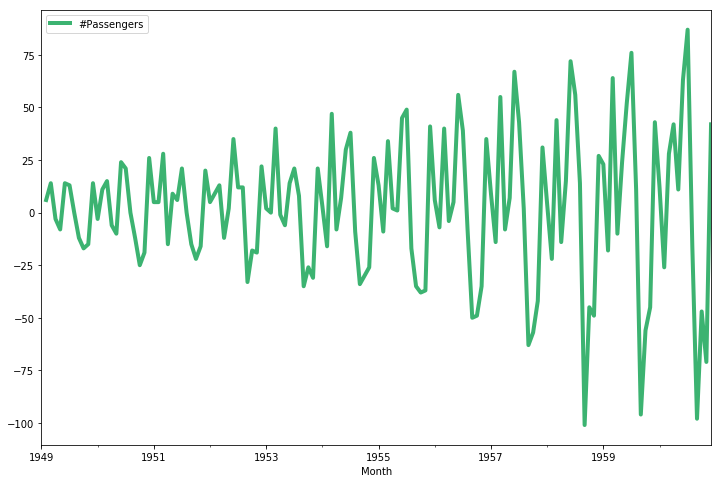

In [6]:
# 2. 定常性と単位根の確認
# 1次差分系列
plt.rcParams['figure.figsize'] = 12, 8
df.diff().plot(linewidth=4, color="mediumseagreen")

In [7]:
# 原系列に対するADF検定
results = sm.tsa.stattools.adfuller(df["#Passengers"])
print('ADF Statistic: %f' % results[0])
print('P-Value: %f' % results[1])

# P値>0.05となり、単位根過程であるという帰無仮説を棄却できなかった

ADF Statistic: 0.815369
P-Value: 0.991880


Text(0, 0.5, 'Residual')

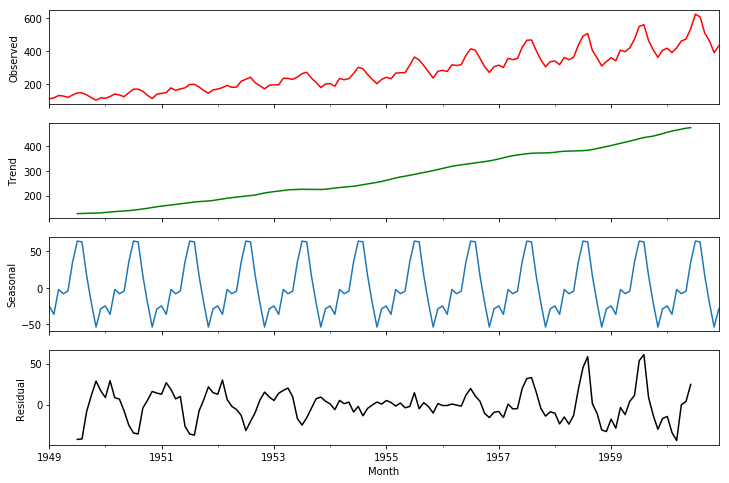

In [8]:
# 3. トレンド(と季節成分)の抽出
# トレンド成分と季節成分, 残差を抽出する
fig, axes = plt.subplots(4, 1, sharex=True)

decomposition = sm.tsa.seasonal_decompose(df, model ='additive')
decomposition.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')


In [9]:
# # 考えられるパラメータの組み合わせを全て作成
# max_p = 1 #2
# max_d = 1
# max_q = 1
# max_sp = 1
# max_sd = 1
# max_sq = 1
# params = []

# for p in range(0, max_p + 1):
#     for d in range(0, max_d + 1): 
#         for q in range(0, max_q + 1): 
#             for sp in range(0, max_sp + 1):
#                 for sd in range(0, max_sd + 1): 
#                     for sq in range(0, max_sq + 1): 
#                         params.append([p,d,q,sp,sd,sq])
# params[:3]         
# params = [[0,0,0,1,0,0], [0,0,0,1,1,0]]

# 考えられるパラメータの組み合わせを全て作成
max_p = 0 #2
max_d = 0
max_q = 0
max_sp = 1
max_sd = 1
max_sq = 0
params = []

for p in range(0, max_p + 1):
    for d in range(0, max_d + 1): 
        for q in range(0, max_q + 1): 
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1): 
                    for sq in range(0, max_sq + 1): 
                        params.append([p,d,q,sp,sd,sq])
params

[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 1, 0]]

In [10]:
# 日付形式で読み込む
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df_season = pd.read_csv('df_season.csv', index_col='Month', date_parser=dateparse, dtype='float')

In [11]:
df_season.shape

(144, 1)

In [12]:
df.shape

(144, 1)

In [13]:
# 最終的に予測したいのはxxxのため, テスト期間も繁忙期に合わせる
df_s = df.head(120)
df_season_s = df_season.head(120)

# テストするため, 学習用とテスト用データの分割
y_train, y_test = df_s.head(108), df_s.tail(12)
X_train, X_test = df_season_s.head(108), df_season_s.tail(12)

# AIC計算用のメソッドを作成
def aic_calculater(param):
    aic = sm.tsa.statespace.SARIMAX(
                                endog=y_train, exog=X_train, trend="n", order=(param[0], param[1], param[2]),
                                seasonal_order=(param[3], param[4], param[5], 52), enforce_invertibility = False, enforce_stationarity = False).fit().aic
    return aic
 

In [14]:
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.head())
print(y_test.head())
print(X_train.head())
print(X_test.head())


(108, 1)
(12, 1)
(108, 1)
(12, 1)
            #Passengers
Month                  
1949-01-01        112.0
1949-02-01        118.0
1949-03-01        132.0
1949-04-01        129.0
1949-05-01        121.0
            #Passengers
Month                  
1958-01-01        340.0
1958-02-01        318.0
1958-03-01        362.0
1958-04-01        348.0
1958-05-01        363.0
            season
Month             
1949-01-01     1.0
1949-02-01     1.0
1949-03-01     2.0
1949-04-01     2.0
1949-05-01     2.0
            season
Month             
1958-01-01    37.0
1958-02-01    37.0
1958-03-01    38.0
1958-04-01    38.0
1958-05-01    38.0


In [15]:
aic_list = []
for param in params:
    aic_list.append(aic_calculater(param))

In [16]:
# AICが小さくなる順にのパラメータの組み合わせを並べ変え
aic_df = pd.DataFrame({"params": params, "aic": aic_list})
aic_df.sort_values("aic", inplace=True)
aic_df.head(10)

,params,aic
3,"[0, 0, 0, 1, 1, 0]",44.557080
2,"[0, 0, 0, 1, 0, 0]",586.180135
1,"[0, 0, 0, 0, 1, 0]",597.276558
0,"[0, 0, 0, 0, 0, 0]",1165.208329


In [17]:
# AICが最小のパラメータを当てはめる
model = sm.tsa.statespace.SARIMAX(
                                endog=y_train, exog=X_train, trend="n", order=(0, 0, 0),
                                seasonal_order=(1, 1, 0, 12),  enforce_invertibility = False, enforce_stationarity = False)

results = model.fit()


In [18]:
# テスト期間の予測値を出力する

y_pred = results.get_prediction(
                                start = pd.to_datetime("1958-01"),
                                end = pd.to_datetime("1958-12"),
                                exog = X_test, dynamic=False)


# y_pred = results.get_prediction(
#                                 start = pd.to_datetime("1958-01"),
#                                 end = pd.to_datetime("1961-06"),
#                                 exog = X_test, dynamic=False)


# y_pred = results.get_prediction(
#                                 start = pd.to_datetime("1949-01"),
#                                 end = pd.to_datetime("1957-03"),
#                                 exog = X_test, dynamic=False)

In [19]:
# 点推定での予測値と区間推定での予測値を取り出す
pred_mean = y_pred.predicted_mean
pred_ci = y_pred.conf_int(alpha = .05)

In [20]:
# MAPEを算出
print(y_test.shape)
print(pred_mean.shape)

print(y_test.head())
print('---')
print(pred_mean.head())

(12, 1)
(12,)
            #Passengers
Month                  
1958-01-01        340.0
1958-02-01        318.0
1958-03-01        362.0
1958-04-01        348.0
1958-05-01        363.0
---
1958-01-01    347.836216
1958-02-01    333.334648
1958-03-01    389.409437
1958-04-01    381.122827
1958-05-01    388.266132
Freq: MS, dtype: float64


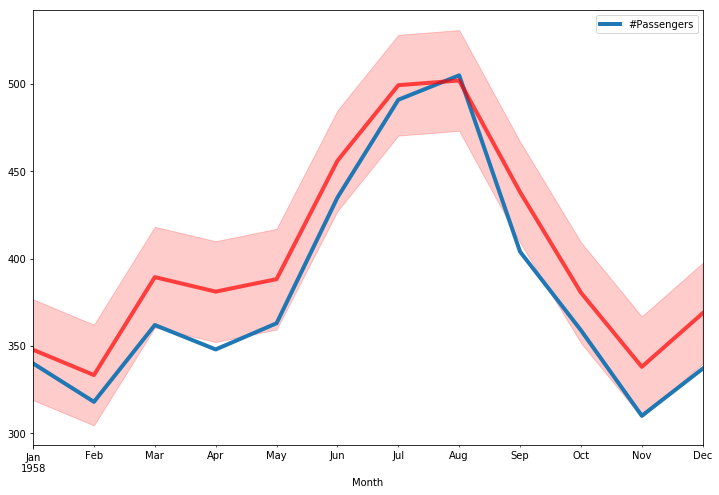

In [21]:
# 予測値と実測値の折れ線グラフの描画
y_test.plot(label='observed', linewidth=4)
pred_mean.plot(label='forecast', alpha=.7, color = "r", linewidth=4)
# 区間予測の折れ線グラフを描画
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='r', alpha=.2)

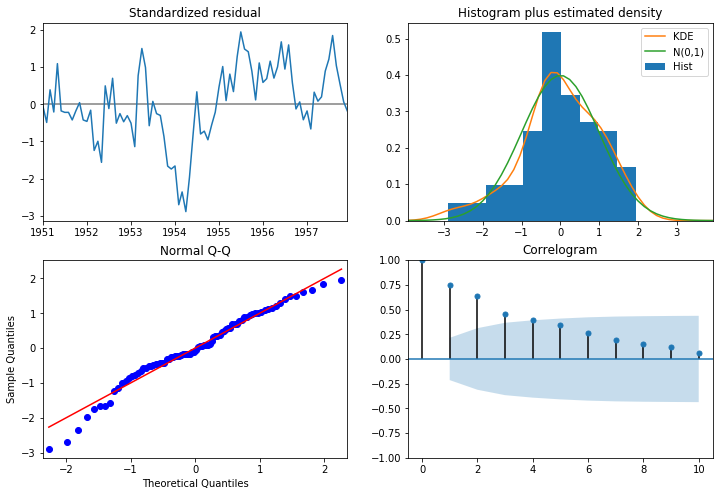

In [22]:
# 残差を確認する
plot = results.plot_diagnostics()

In [23]:
# 手元にある直近までのデータを全てモデルへ
model = sm.tsa.statespace.SARIMAX(
                                endog=df_s, exog=df_season_s, trend="n", order=(0, 0, 0),
                                seasonal_order=(1, 1, 0, 12), enforce_invertibility = False, enforce_stationarity = False)

results = model.fit()


df_season_end = df_season.tail(24)

# 未来の予測値を算出
forecast = results.get_forecast(steps=len(df_season_end), exog=df_season_end)
# forecast = results.get_forecast(steps=len(df), exog=df)

# # 予測値を可視化
lower = forecast.conf_int()["lower #Passengers"]
upper = forecast.conf_int()["upper #Passengers"]


In [24]:
forecast.conf_int().head()

,lower #Passengers,upper #Passengers
1959-01-01,339.161994,401.293893
1959-02-01,317.255855,379.387755
1959-03-01,361.384914,423.516814
1959-04-01,347.455310,409.587210
1959-05-01,362.361449,424.493349


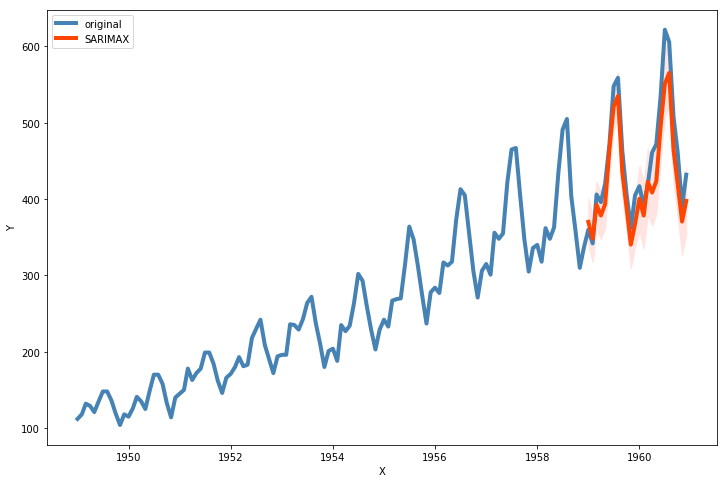

In [25]:
plt.plot(df, label='original', linewidth=4, color="steelblue")
plt.plot(forecast.predicted_mean, label='SARIMAX', c="orangered", linewidth=4)
plt.fill_between(
                 forecast.conf_int().index, 
                 lower, upper,
                 color='mistyrose')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()